In [1]:
# STEP 1: Install and import the program
#
# clone the repo to your local directory
# navigate to the \bifacialvf directory which contains setup
# run pip install -e .

import bifacialvf    
import os
# change directory to \bifacialvf\ root
os.chdir(os.path.dirname(bifacialvf.__file__))
%pwd

'c:\\users\\mikm\\projects\\bifacialvf\\bifacialvf'

In [2]:
#2. Set the Values of your test
# Remember all values are normalized to your panel length (slope, which will equal 1).
# If your slope is different than 1 m, desired C and rtr (or D) will need to be 
# divided by the slope length.
# i.e.: panel 1mx1.59m, in portrait mode means slope = 1.59. For a height C of 1m, C = 1/1.59. 
#         For a rtr of 1.5m, D=0.51519/1.59 if beta tilt angle = 10 

# Set mandatory variables
beta = 10                   # PV tilt (deg)
sazm = 180                  # PV Azimuth(deg)
C = 1                      # GroundClearance(panel slope lengths)
rtr = 1.5              # row to row spacing in panel lengths. 
GCR = 1.0/rtr             # Ground Cover Ratio

TMYtoread = "data/724010TYA.csv"   # VA Richmond
writefiletitle = "data/Output/test.csv"

# Set optional variables.  These are the default values
rowType = "interior"        # RowType(first interior last single)
transFactor = 0.013         # TransmissionFactor(open area fraction)
cellRows = 6                # CellRows(# hor rows in panel)   This is the number of irradiance values returned along module chord
PVfrontSurface = "glass"    # PVfrontSurface(glass or ARglass)
PVbackSurface = "glass"     # PVbackSurface(glass or ARglass)
albedo = 0.62               # ground albedo beneath system
# 1-axis tracking instructions (optional)
tracking=False
backtrack=True       # backtracking optimization as defined in pvlib



Notice that fixed systems use the parameter `D`, which is the space between the end of one panel and the beginning of the end, so it relates to the inclination angle `beta`. To go from a `rtr` value to `D`, you can use the following:

    x1 = cos(beta)
    rtr = D + x1
    D = rtr - x1

    # all dimensions are relative to module height
    # in other words, consider a module height of 1 arb. unit

    #   <--rtr=x1+D--><--rtr=x1+D--><--rtr=x1+D-->
    #  :\\     row   :\\     row   :\\     row   :\\
    #  : \\`    0    : \\     1    : \\     2   /: \\
    #  h  \\  `      h  \\         h  \\      /  h  \\
    #  :   \\    `   :   \\        :   \\   /    :   \\ pi-beta
    #  :.x1.\\...D..`:.x1.\\...D...:.x1.\\/...D..:.x1.\\...
    #  :               `   <------x-----/|
    #  C                  `           /
    #  :              angA   `      /  angB
    #  +------------------------`-/---------------------
    #                            x

In [3]:
#3. Call the function.



bifacialvf.simulate(TMYtoread, writefiletitle, beta, sazm, 
                C=C, rtr=rtr, rowType=rowType, transFactor=transFactor, cellRows=cellRows,
                PVfrontSurface=PVfrontSurface, PVbackSurface=PVbackSurface, albedo=albedo, 
                tracking=tracking, backtrack=backtrack, )
    

 
********* 
Running Simulation for TMY3:  data/724010TYA.csv
Location:   "RICHMOND INTERNATIONAL AP"
Lat:  37.517  Long:  -77.317  Tz  -5.0
Parameters: beta:  10   Sazm:  180   Height:  1   rtr separation:  1.5   Row type:  interior   Albedo:  0.62
Saving into data/Output/test.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.4516243822347115
Actual distance between rows =  0.515192246987792
 
Finished


In [4]:
#4. Load the results from the resultfile
(data, metadata) = bifacialvf.loadVFresults(writefiletitle)
#print data.keys()
# calculate average front and back global tilted irradiance across the module chord
data['GTIFrontavg'] = data[['No_1_RowFrontGTI', 'No_2_RowFrontGTI','No_3_RowFrontGTI','No_4_RowFrontGTI','No_5_RowFrontGTI','No_6_RowFrontGTI']].mean(axis=1)
data['GTIBackavg'] = data[['No_1_RowBackGTI', 'No_2_RowBackGTI','No_3_RowBackGTI','No_4_RowBackGTI','No_5_RowBackGTI','No_6_RowBackGTI']].mean(axis=1)

# Print the annual bifacial ratio
frontIrrSum = data['GTIFrontavg'].sum()
backIrrSum = data['GTIBackavg'].sum()
print('The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,backIrrSum/frontIrrSum*100))



The bifacial ratio for ground clearance 1 and rtr spacing 1.5 is: 16.3%


c:\users\mikm\projects\bifacialvf\venv\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


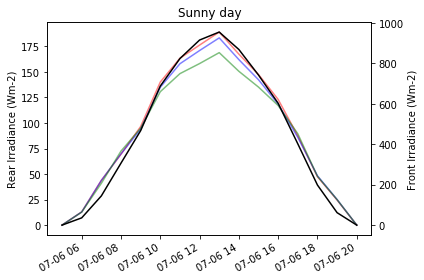

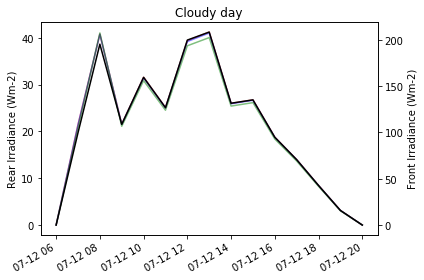

In [5]:
# plot the rear irradiance distribution for a single point in time. 1999-07-06
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

data['GTIBackstd'] = data[['No_1_RowBackGTI', 'No_2_RowBackGTI','No_3_RowBackGTI','No_4_RowBackGTI','No_5_RowBackGTI','No_6_RowBackGTI']].std(axis=1)
data['measdatetime'] = pd.to_datetime(data[['Year', 'Month', 'Day','Hour','Minute']])
singleday = (data['measdatetime'] > '1999-07-06') & (data['measdatetime']<'1999-07-07')
singleday2 = (data['measdatetime'] > '1999-07-12') & (data['measdatetime']<'1999-07-13')

fig, ax = plt.subplots()
ax1 = ax.twinx()
ax1.plot(data['measdatetime'][singleday],data['GTIFrontavg'][singleday],'k')
ax1.set_ylabel('Front Irradiance (Wm-2)')
ax.set_ylabel('Rear Irradiance (Wm-2)')
ax.plot(data['measdatetime'][singleday], data['No_1_RowBackGTI'][singleday],'r' , alpha =0.5)
ax.plot(data['measdatetime'][singleday], data['No_2_RowBackGTI'][singleday], 'b', alpha = 0.5)
ax.plot(data['measdatetime'][singleday], data['No_6_RowBackGTI'][singleday], 'g', alpha = 0.5)
ax.set_title('Sunny day')
fig.autofmt_xdate()
fig.tight_layout()


fig2, ax2 = plt.subplots()
ax3 = ax2.twinx()
ax3.plot(data['measdatetime'][singleday2],data['GTIFrontavg'][singleday2],'k')
ax3.set_ylabel('Front Irradiance (Wm-2)')
ax2.set_ylabel('Rear Irradiance (Wm-2)')
ax2.plot(data['measdatetime'][singleday2], data['No_1_RowBackGTI'][singleday2],'r' , alpha =0.5)
ax2.plot(data['measdatetime'][singleday2], data['No_2_RowBackGTI'][singleday2], 'b', alpha = 0.5)
ax2.plot(data['measdatetime'][singleday2], data['No_6_RowBackGTI'][singleday2], 'g', alpha = 0.5)
ax2.set_title('Cloudy day')
fig2.autofmt_xdate()
fig2.tight_layout()




# Example of 1-axis tracking


In [6]:
# tracker geometry options:
module_height = 4  # module portrait dimension in meters (2-up portrait 'module')
gcr = 0.35   # ground cover ratio,  = module_height / pitch
albedo = 0.3     # ground albedo
hub_height = 2.5   # tracker height at 0 tilt in meters (hub height)
limit_angle = 45 # tracker rotation limit angle

# Set mandatory variables
beta = 0                   # Tracking doesn't allow tilted trackers at the moment.
sazm = 180                  # PV Azimuth(deg) - tracker axis orientation for E-W tracked system.
C = hub_height / module_height                      # GroundClearance(panel slope lengths)
rtr = 1 / gcr              # row to row spacing in panel lengths. 


TMYtoread = "data/724010TYA.csv"   # VA Richmond
writefiletitle = "data/Output/1AxisTest.csv"

# Set optional variables.  These are the default values
rowType = "interior"        # RowType(first interior last single)
transFactor = 0.013         # TransmissionFactor(open area fraction)
cellRows = 6                # CellRows(# hor rows in panel)   This is the number of irradiance values returned along module chord
PVfrontSurface = "ARglass"    # PVfrontSurface(glass or ARglass)
PVbackSurface = "glass"     # PVbackSurface(glass or ARglass)
# 1-axis tracking instructions (optional)
tracking=True
backtrack=True       # backtracking optimization as defined in pvlib


In [7]:
#3. Call the function.

bifacialvf.simulate(TMYtoread, writefiletitle, beta, sazm, 
                C=C, rowType=rowType, transFactor=transFactor, cellRows=cellRows,
                PVfrontSurface=PVfrontSurface, PVbackSurface=PVbackSurface, albedo=albedo, 
                tracking=True, backtrack=backtrack, rtr=rtr, max_angle = limit_angle)
  

 
********* 
Running Simulation for TMY3:  data/724010TYA.csv
Location:   "RICHMOND INTERNATIONAL AP"
Lat:  37.517  Long:  -77.317  Tz  -5.0
Parameters: beta:  0   Sazm:  180   Height:  0.625   rtr separation:  2.857142857142857   Row type:  interior   Albedo:  0.3
Saving into data/Output/1AxisTest.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 ***** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True
Finished


In [8]:
#4. Load the results from the resultfile
(data, metadata) = bifacialvf.loadVFresults(writefiletitle)
#print data.keys()
# calculate average front and back global tilted irradiance across the module chord in 6 points
data['GTIFrontavg'] = data[['No_1_RowFrontGTI', 'No_2_RowFrontGTI','No_3_RowFrontGTI','No_4_RowFrontGTI','No_5_RowFrontGTI','No_6_RowFrontGTI']].mean(axis=1)
data['GTIBackavg'] = data[['No_1_RowBackGTI', 'No_2_RowBackGTI','No_3_RowBackGTI','No_4_RowBackGTI','No_5_RowBackGTI','No_6_RowBackGTI']].mean(axis=1)

# Print the annual bifacial ratio
frontIrrSum = data['GTIFrontavg'].sum()
backIrrSum = data['GTIBackavg'].sum()
print('The 1-axis tracked bifacial ratio for ground clearance {} and row to row {} is: {:.1f}%\n\n *****'.format(C,rtr,backIrrSum/frontIrrSum*100))


The 1-axis tracked bifacial ratio for ground clearance 0.625 and row to row 2.857142857142857 is: 10.1%

 *****
